In [1]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots

include("helpers.jl")

stratifyarchitecturedimension (generic function with 2 methods)

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "data/full_opt_15KeV/"

"data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_raw_df = DataFrame(
    DVAR1=Float64[],
    DVAR2=Float64[],
    DVAR3=Float64[],
    DVAR4=Float64[],
    DVAR5=Float64[],
    DVAR6=Float64[],
    DVAR7=Float64[],
    DVAR8=Float64[],
    DVAR9=Float64[],
    DVAR10=Float64[],
    DVAR11=Float64[],
    DVAR12=Float64[],
    DVAR13=Float64[],
    DVAR14=Float64[]
)
y_raw_df = DataFrame(
    OBJ1=Float64[],
    OBJ2=Float64[],
    OBJ3=Float64[],
    OBJ4=Float64[],
    OBJ5=Float64[],
    OBJ6=Float64[]
)

x_raw_df, y_raw_df = readjsonsfromdirectory(target_directory, x_raw_df, y_raw_df);

In [4]:
first(x_raw_df, 5)

,DVAR1,DVAR2,DVAR3,DVAR4,DVAR5,DVAR6,DVAR7,DVAR8,DVAR9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.7561,51.3217,117.941,1.58493,1.80198,54.7152,46.9082,-73.5071,-40.3815
2,10.9999,59.0984,114.967,1.42384,1.632,94.2397,329.885,-69.9227,-61.0211
3,10.5114,67.2372,102.822,1.56805,1.76104,232.236,482.175,-34.4811,-31.0546
4,9.79078,132.062,157.89,1.06108,1.4818,91.7427,178.76,-35.0063,-28.2593
5,10.8851,33.3697,144.044,1.67219,1.83251,433.296,420.627,-32.8443,-26.0774


In [5]:
first(y_raw_df, 5)

,OBJ1,OBJ2,OBJ3,OBJ4,OBJ5,OBJ6
,Float64,Float64,Float64,Float64,Float64,Float64
1,91.0,0.0624,99.34,0.07639,0.07035,0.05352
2,92.69,0.0579,110.26,0.07544,0.03639,0.05048
3,70.87,0.0649,80.55,0.07192,0.04194,0.02244
4,16.85,0.0756,183.99,0.01274,0.01483,0.01153
5,66.16,0.0674,56.7,0.06682,0.03004,0.04468


## EDA

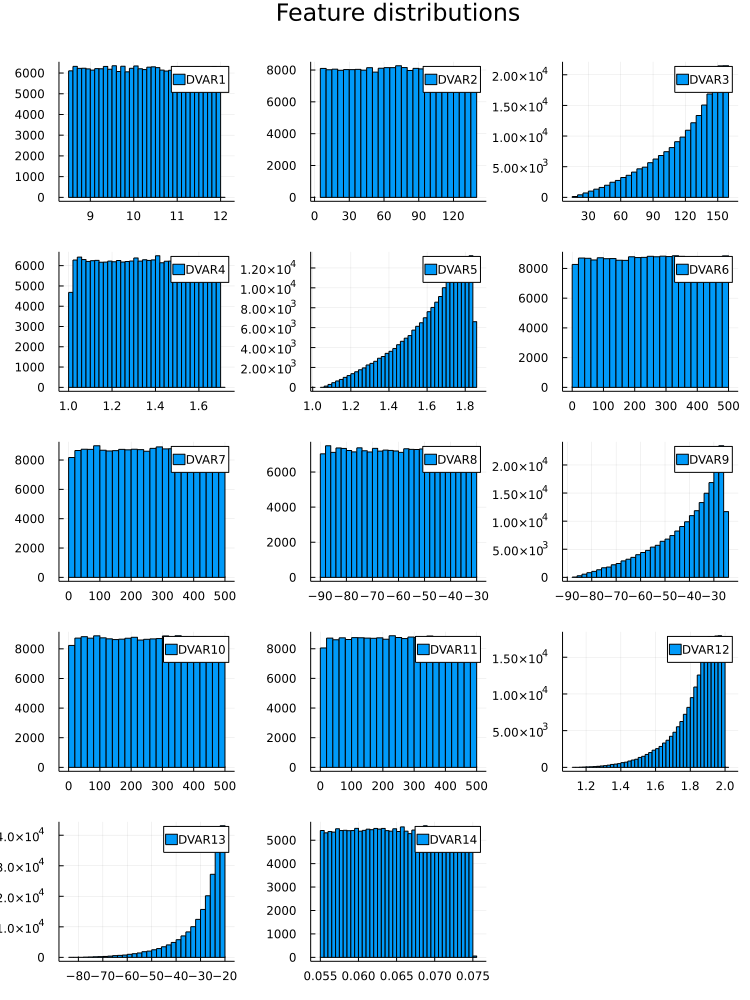

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_raw_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

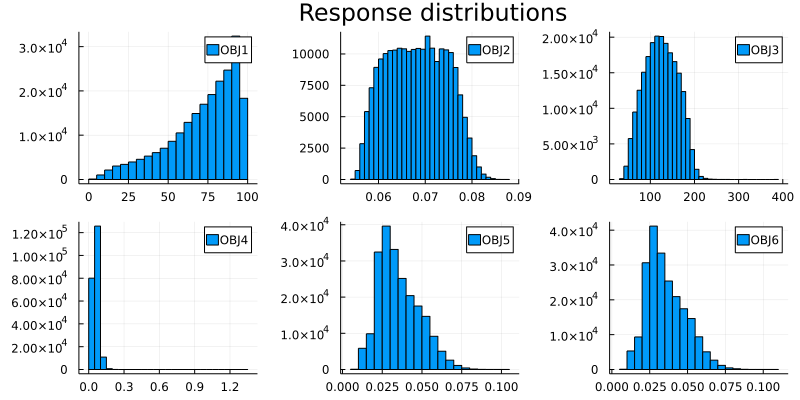

In [7]:
# plot responses
l = @layout [grid(2,3)]

subplots = []
for i in 1:6
    hist = histogram(y_raw_df[:, "OBJ$i"], label="OBJ$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout = l, size=(800, 400), plot_title="Response distributions")

In [8]:
# some cuts
abnormally_high_rfq_length = 220. # OBJ3
abnormally_high_longitudinal_emittance = 0.2 # OBJ4
abnormally_high_x_emittance = 0.08 # OBJ5
abnormally_high_y_emittance = 0.08 # OBJ6

non_outlier_conditional = (y_raw_df[:, "OBJ3"] .<= abnormally_high_rfq_length) .&
    (y_raw_df[:, "OBJ4"] .<= abnormally_high_longitudinal_emittance) .&
    (y_raw_df[:, "OBJ5"] .<= abnormally_high_x_emittance) .&
    (y_raw_df[:, "OBJ6"] .<= abnormally_high_y_emittance)

# process data
x_outliers_df = x_raw_df[(!).(non_outlier_conditional), :];
y_outliers_df = y_raw_df[(!).(non_outlier_conditional), :];

x_df = x_raw_df[non_outlier_conditional, :];
y_df = y_raw_df[non_outlier_conditional, :];

In [9]:
# how many outliers are there?
sum((!).(non_outlier_conditional))

717

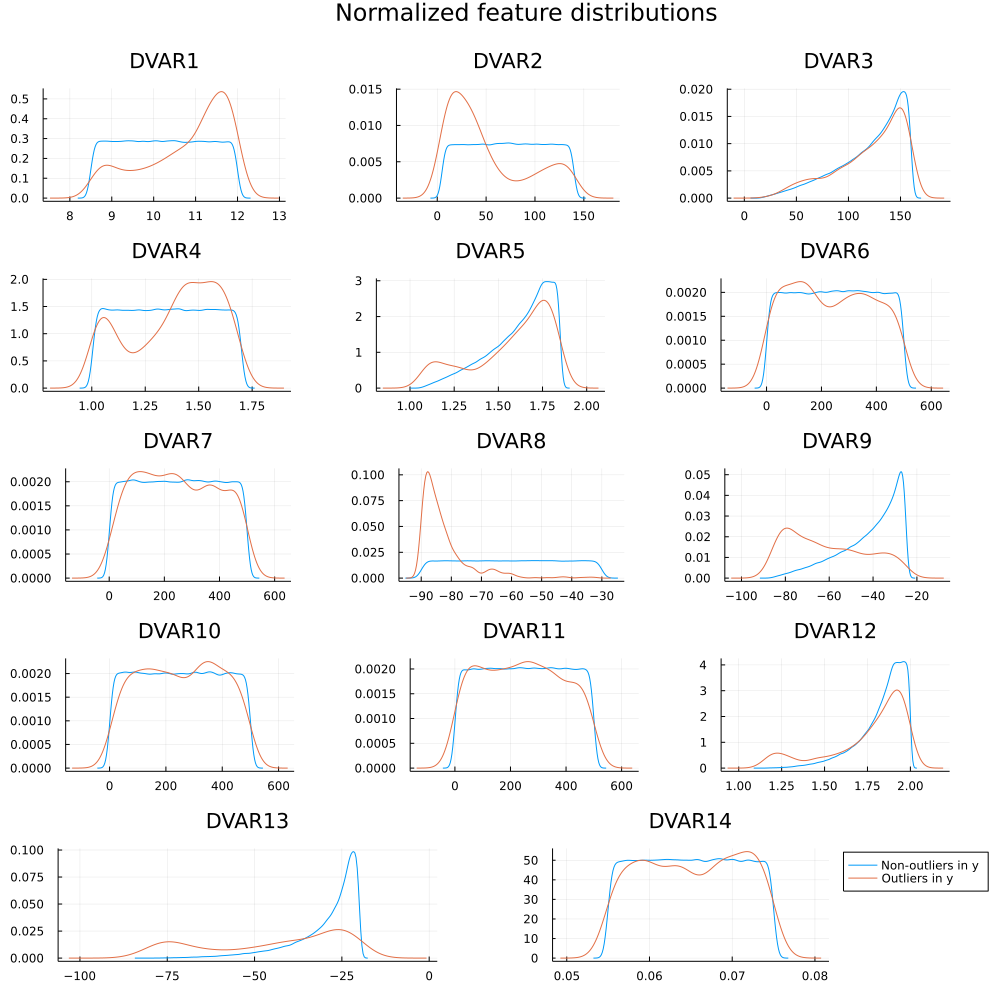

In [10]:
# features split by outlier
l = @layout [a b c; d e f; g h i; j k l; m n]

subplots = []
for i in 1:14
    sp = density(x_df[:, "DVAR$i"]; label=(i == 14 ? "Non-outliers in y" : ""), legend=(i==14), title="DVAR$i")
    density!(sp, x_outliers_df[:, "DVAR$i"]; label=(i == 14 ? "Outliers in y" : ""), legend=:outertopright)
    push!(subplots, sp)
end

plot(subplots..., layout=l, size=(1000, 1000), plot_title="Normalized feature distributions")

## Data preprocessing

In [11]:
# scaler
mutable struct MinMaxScaler
    data_min::Float64
    data_max::Float64
end

function fit!(scaler, data)
    scaler.data_min = minimum(data); scaler.data_max = maximum(data)
end

function transform(scaler, data)
    [2*(d - scaler.data_min)/(scaler.data_max - scaler.data_min) - 1 for d in data]
end

function inverse_transform(scaler, data_scaled)
    [0.5*(scaler.data_max - scaler.data_min)*(d_s + 1) + scaler.data_min for d_s in data_scaled]
end

function fit_transform(data)
    scaler = MinMaxScaler(0., 0.)
    fit!(scaler, data)
    transform(scaler, data)
end

# sanity checking
data_test = [1., 2., 3., 4., 5.]
scaler_test = MinMaxScaler(0., 0.)
fit!(scaler_test, data_test)
data_test_scaled = transform(scaler_test, data_test)
@assert(maximum(data_test_scaled) == 1.0)
@assert(minimum(data_test_scaled) == -1.0)
@assert(maximum(data_test) == maximum(inverse_transform(scaler_test, data_test_scaled)))
@assert(minimum(data_test) == minimum(inverse_transform(scaler_test, data_test_scaled)))

In [12]:
# drop any columns needed
select!(x_df, Not(x_columns_to_drop));
select!(y_df, Not(y_columns_to_drop));

In [13]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [14]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [15]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [16]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [17]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, 50, x->σ.(x)),
        Dense(50, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [18]:
# organizing data into batches
batch_size = 512
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [19]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 2500
training_losses = Float64[]
epochs = Int64[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=19.734171906221594
epoch 2, loss=10.938604568601319
epoch 3, loss=8.065444930859996
epoch 4, loss=7.3443873291899635
epoch 5, loss=6.817089639558908
epoch 6, loss=6.347263694087659
epoch 7, loss=6.043859615932673
epoch 8, loss=5.75608518308691
epoch 9, loss=5.552292259307437
epoch 10, loss=5.392162890821597
epoch 11, loss=5.277741141937603
epoch 12, loss=5.147437228373177
epoch 13, loss=5.061264685721044
epoch 14, loss=4.9642083612560395
epoch 15, loss=4.8881181610113105
epoch 16, loss=4.8606124622896765
epoch 17, loss=4.738257865584009
epoch 18, loss=4.677029094357417
epoch 19, loss=4.605837331761767
epoch 20, loss=4.527704748960403
epoch 21, loss=4.476459588331097
epoch 22, loss=4.4098158449542835
epoch 23, loss=4.346693760440599
epoch 24, loss=4.313122581087048
epoch 25, loss=4.259155383501773
epoch 26, loss=4.196774781629047
epoch 27, loss=4.167351559383532
epoch 28, loss=4.097680895619414
epoch 29, loss=4.07113461218636
epoch 30, loss=4.022807574711535
epoch 31, loss

epoch 242, loss=3.117858000681725
epoch 243, loss=3.1291530060461614
epoch 244, loss=3.1241279307433087
epoch 245, loss=3.1531553505071432
epoch 246, loss=3.1283204635138473
epoch 247, loss=3.116786859728916
epoch 248, loss=3.1476385694632874
epoch 249, loss=3.14045277632459
epoch 250, loss=3.1226263161868553
epoch 251, loss=3.138126604009934
epoch 252, loss=3.118614717251281
epoch 253, loss=3.139868413415782
epoch 254, loss=3.140457406537765
epoch 255, loss=3.1220610968536504
epoch 256, loss=3.1237842917619476
epoch 257, loss=3.1231030416497547
epoch 258, loss=3.118517792617693
epoch 259, loss=3.1079472246526922
epoch 260, loss=3.108373260738794
epoch 261, loss=3.1113243991608917
epoch 262, loss=3.105870891811323
epoch 263, loss=3.113149754595564
epoch 264, loss=3.1233591852768896
epoch 265, loss=3.124083361316701
epoch 266, loss=3.1906549417958447
epoch 267, loss=3.098905934995367
epoch 268, loss=3.1038088131173995
epoch 269, loss=3.1062125380636507
epoch 270, loss=3.117427729344794


epoch 480, loss=2.996542722209269
epoch 481, loss=2.9946093416608783
epoch 482, loss=2.993062912724537
epoch 483, loss=2.9921283283778997
epoch 484, loss=2.9767073672666697
epoch 485, loss=2.999260639188476
epoch 486, loss=2.979244056763274
epoch 487, loss=2.981808468609958
epoch 488, loss=2.981246143669316
epoch 489, loss=2.9983179491323084
epoch 490, loss=2.993286943077504
epoch 491, loss=2.9887217555449133
epoch 492, loss=2.9766543321814214
epoch 493, loss=2.982484873952695
epoch 494, loss=2.9770598261157786
epoch 495, loss=2.993890828998532
epoch 496, loss=2.973474402521059
epoch 497, loss=2.9909935616030268
epoch 498, loss=2.993873633669864
epoch 499, loss=2.983959172522938
epoch 500, loss=3.03201831364418
epoch 501, loss=2.9706730913590604
epoch 502, loss=2.992800912998799
epoch 503, loss=2.971687539652028
epoch 504, loss=2.9884281193417697
epoch 505, loss=2.98009357877296
epoch 506, loss=2.987341304288824
epoch 507, loss=2.985084596603247
epoch 508, loss=2.962703743831637
epoch 

epoch 717, loss=2.8747556281491087
epoch 718, loss=2.875290893236918
epoch 719, loss=2.879660845980875
epoch 720, loss=2.8900981825394614
epoch 721, loss=2.88224962750585
epoch 722, loss=2.8746872626505082
epoch 723, loss=2.8973686224308044
epoch 724, loss=2.8723239248933847
epoch 725, loss=2.8854972109427077
epoch 726, loss=2.883152037673789
epoch 727, loss=2.891190306634017
epoch 728, loss=2.8707465231602947
epoch 729, loss=2.882273800860246
epoch 730, loss=2.8655315752075525
epoch 731, loss=2.874250740247978
epoch 732, loss=2.879164016621127
epoch 733, loss=2.892775421695303
epoch 734, loss=2.8732685631265906
epoch 735, loss=2.878505559043877
epoch 736, loss=2.876725213839975
epoch 737, loss=2.872226333735174
epoch 738, loss=2.8651497677937336
epoch 739, loss=2.8716577899313016
epoch 740, loss=2.8923150809058438
epoch 741, loss=2.8707592064629774
epoch 742, loss=2.8701696339539744
epoch 743, loss=2.8634854993983745
epoch 744, loss=2.858994725218816
epoch 745, loss=2.8688035183980642

epoch 955, loss=2.821248494774065
epoch 956, loss=2.820137877319209
epoch 957, loss=2.815613200750806
epoch 958, loss=2.815738190887597
epoch 959, loss=2.813525817690505
epoch 960, loss=2.823637106229777
epoch 961, loss=2.8196433348215653
epoch 962, loss=2.811493409552519
epoch 963, loss=2.829330033595001
epoch 964, loss=2.8085370228094
epoch 965, loss=2.8223842011317255
epoch 966, loss=2.828336547685855
epoch 967, loss=2.817858475036701
epoch 968, loss=2.827967661819562
epoch 969, loss=2.8128154602770308
epoch 970, loss=2.8067049928672585
epoch 971, loss=2.81227685477365
epoch 972, loss=2.8571755564522583
epoch 973, loss=2.8063891178233917
epoch 974, loss=2.820830324061896
epoch 975, loss=2.8102127686124896
epoch 976, loss=2.8197251758700284
epoch 977, loss=2.811628726682075
epoch 978, loss=2.8215517228333042
epoch 979, loss=2.817607322838031
epoch 980, loss=2.808795331082905
epoch 981, loss=2.815688478937806
epoch 982, loss=2.814404835248461
epoch 983, loss=2.8255584790628285
epoch 9

epoch 1187, loss=2.7806361507208135
epoch 1188, loss=2.7682262268263167
epoch 1189, loss=2.787296784474998
epoch 1190, loss=2.7746163032436613
epoch 1191, loss=2.7725223924591185
epoch 1192, loss=2.7917987089305627
epoch 1193, loss=2.7782430382535765
epoch 1194, loss=2.7703929491611166
epoch 1195, loss=2.7788137120699794
epoch 1196, loss=2.783818014034204
epoch 1197, loss=2.7766348730299595
epoch 1198, loss=2.7794901842924657
epoch 1199, loss=2.7696096210440833
epoch 1200, loss=2.7684490686137786
epoch 1201, loss=2.7826719757391136
epoch 1202, loss=2.7885406010376443
epoch 1203, loss=2.7780472227748056
epoch 1204, loss=2.7653921784930957
epoch 1205, loss=2.7776591389014045
epoch 1206, loss=2.773072577318866
epoch 1207, loss=2.7748771836720065
epoch 1208, loss=2.796744633463194
epoch 1209, loss=2.765871553487734
epoch 1210, loss=2.771008809501987
epoch 1211, loss=2.7716722748907925
epoch 1212, loss=2.7890031964672177
epoch 1213, loss=2.764976136453619
epoch 1214, loss=2.776623852190083


epoch 1417, loss=2.758781652794016
epoch 1418, loss=2.739558752424065
epoch 1419, loss=2.75178307162205
epoch 1420, loss=2.746285196479969
epoch 1421, loss=2.743535280406475
epoch 1422, loss=2.762198304100836
epoch 1423, loss=2.751264052193952
epoch 1424, loss=2.7680185295358983
epoch 1425, loss=2.761381404886918
epoch 1426, loss=2.748041018616951
epoch 1427, loss=2.73462221934101
epoch 1428, loss=2.745191356138408
epoch 1429, loss=2.751710005450655
epoch 1430, loss=2.7614401943739764
epoch 1431, loss=2.7444572400341163
epoch 1432, loss=2.7411827977411996
epoch 1433, loss=2.7374072940189573
epoch 1434, loss=2.7429823520344163
epoch 1435, loss=2.742983305753201
epoch 1436, loss=2.737396064601537
epoch 1437, loss=2.7368277758886124
epoch 1438, loss=2.75018085239099
epoch 1439, loss=2.7486135282942143
epoch 1440, loss=2.746712724211639
epoch 1441, loss=2.7464286319804945
epoch 1442, loss=2.736815817447582
epoch 1443, loss=2.75059377139353
epoch 1444, loss=2.741947351070966
epoch 1445, los

epoch 1647, loss=2.722606197154964
epoch 1648, loss=2.7151046064025084
epoch 1649, loss=2.713572894443794
epoch 1650, loss=2.71944985701543
epoch 1651, loss=2.716258668716802
epoch 1652, loss=2.7103253466021977
epoch 1653, loss=2.7330197700144625
epoch 1654, loss=2.7179491683594637
epoch 1655, loss=2.7095731890987604
epoch 1656, loss=2.7424660624167
epoch 1657, loss=2.717644603863179
epoch 1658, loss=2.711905866957683
epoch 1659, loss=2.728555603520074
epoch 1660, loss=2.7211847500865387
epoch 1661, loss=2.7176052846188035
epoch 1662, loss=2.720029057664728
epoch 1663, loss=2.718944490614796
epoch 1664, loss=2.7216462120920304
epoch 1665, loss=2.7124213022876944
epoch 1666, loss=2.7175530076683816
epoch 1667, loss=2.7179136665778647
epoch 1668, loss=2.71365066231891
epoch 1669, loss=2.715793311330347
epoch 1670, loss=2.7209137729720263
epoch 1671, loss=2.740489973610723
epoch 1672, loss=2.7128976811185996
epoch 1673, loss=2.718284205148583
epoch 1674, loss=2.713875745831237
epoch 1675,

epoch 1877, loss=2.6924044551326802
epoch 1878, loss=2.69339967260899
epoch 1879, loss=2.691758198332149
epoch 1880, loss=2.704732394768042
epoch 1881, loss=2.7019229567499434
epoch 1882, loss=2.698980330324764
epoch 1883, loss=2.7242184264019484
epoch 1884, loss=2.691422558313527
epoch 1885, loss=2.6938797357544266
epoch 1886, loss=2.6881123422982625
epoch 1887, loss=2.69318914433465
epoch 1888, loss=2.6933963770718075
epoch 1889, loss=2.695993269646288
epoch 1890, loss=2.692066562806908
epoch 1891, loss=2.6897106226489407
epoch 1892, loss=2.7069077881692905
epoch 1893, loss=2.6961400517918537
epoch 1894, loss=2.703151287890283
epoch 1895, loss=2.6915260907991128
epoch 1896, loss=2.689771471269349
epoch 1897, loss=2.707606438962662
epoch 1898, loss=2.702969240286016
epoch 1899, loss=2.6916874550652667
epoch 1900, loss=2.6955366257822337
epoch 1901, loss=2.69693881898346
epoch 1902, loss=2.693616911750512
epoch 1903, loss=2.6938159069102117
epoch 1904, loss=2.6946472715552563
epoch 190

epoch 2108, loss=2.695745852842142
epoch 2109, loss=2.6718847334473885
epoch 2110, loss=2.688763951208423
epoch 2111, loss=2.6829236047921783
epoch 2112, loss=2.6907873585282664
epoch 2113, loss=2.675110985720881
epoch 2114, loss=2.675081007132036
epoch 2115, loss=2.684865493412386
epoch 2116, loss=2.683596156145283
epoch 2117, loss=2.6884928319095094
epoch 2118, loss=2.6750551885703993
epoch 2119, loss=2.675535248497937
epoch 2120, loss=2.6797999954661185
epoch 2121, loss=2.6745735470356173
epoch 2122, loss=2.6709574811627506
epoch 2123, loss=2.6793132927932866
epoch 2124, loss=2.6730718357047643
epoch 2125, loss=2.675200546297102
epoch 2126, loss=2.68307602026628
epoch 2127, loss=2.6756239657998013
epoch 2128, loss=2.6780174263988052
epoch 2129, loss=2.681424428395987
epoch 2130, loss=2.684037725728905
epoch 2131, loss=2.6799406506217833
epoch 2132, loss=2.6711463303473826
epoch 2133, loss=2.6832611250803877
epoch 2134, loss=2.674114463728389
epoch 2135, loss=2.6861021922566963
epoch

epoch 2339, loss=2.6626592335382218
epoch 2340, loss=2.6590937037902127
epoch 2341, loss=2.661629726727494
epoch 2342, loss=2.6624776469401157
epoch 2343, loss=2.6644642938629453
epoch 2344, loss=2.666781912577527
epoch 2345, loss=2.6701950812337745
epoch 2346, loss=2.666310420145052
epoch 2347, loss=2.670893774320334
epoch 2348, loss=2.663251885510536
epoch 2349, loss=2.6687167907097886
epoch 2350, loss=2.669924126295651
epoch 2351, loss=2.6753979995806496
epoch 2352, loss=2.661512621912623
epoch 2353, loss=2.663433531157698
epoch 2354, loss=2.6670679290824997
epoch 2355, loss=2.662259007301976
epoch 2356, loss=2.6872859647896425
epoch 2357, loss=2.6654474707838003
epoch 2358, loss=2.659819475278187
epoch 2359, loss=2.6649196546082496
epoch 2360, loss=2.659301778112214
epoch 2361, loss=2.6587365649748915
epoch 2362, loss=2.663980630669599
epoch 2363, loss=2.6686412317876504
epoch 2364, loss=2.6619262050782826
epoch 2365, loss=2.669706919299634
epoch 2366, loss=2.6757377311684896
epoch

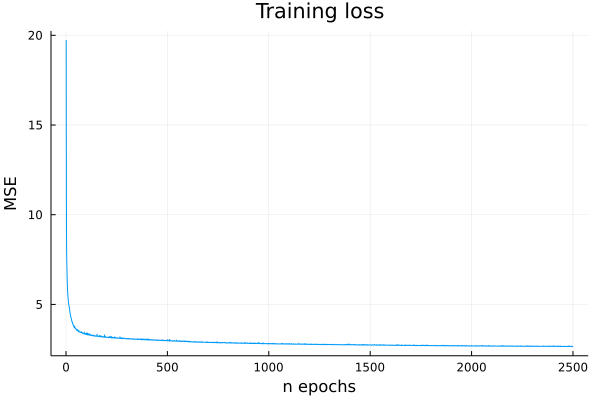

In [20]:
# plot the results
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [21]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [22]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9341416441978744
r2 on test set: 0.9335365548298483


In [23]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [24]:
size(x_train, 2)

14

In [25]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9341363221569426
adjustedr2 on test set: 0.9335150659905055


In [26]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.05968412540680794
mae on test set: 0.05989288445683248


In [27]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.018739716476927265
mae on test set for OBJ1: 0.01898454090245678
mae on training set for OBJ2: 0.07481109786884416
mae on test set for OBJ2: 0.07539411182422785
mae on training set for OBJ3: 0.014587870764185074
mae on test set for OBJ3: 0.014738205975374808
mae on training set for OBJ4: 0.03138150432508775
mae on test set for OBJ4: 0.03175991262137079
mae on training set for OBJ5: 0.10958253259290168
mae on test set for OBJ5: 0.10987998206345713
mae on training set for OBJ6: 0.10900203041290174
mae on test set for OBJ6: 0.10860055335410748


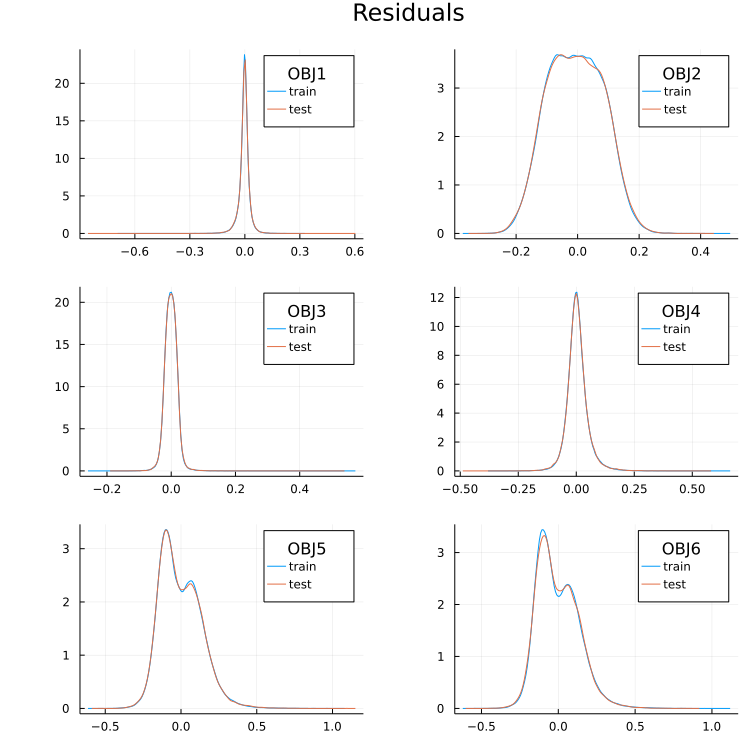

In [28]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

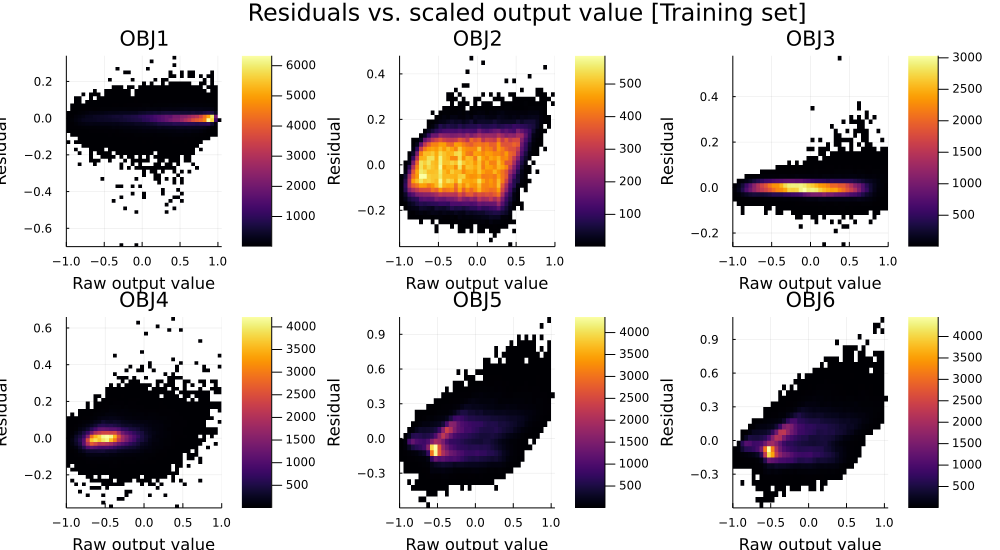

In [29]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

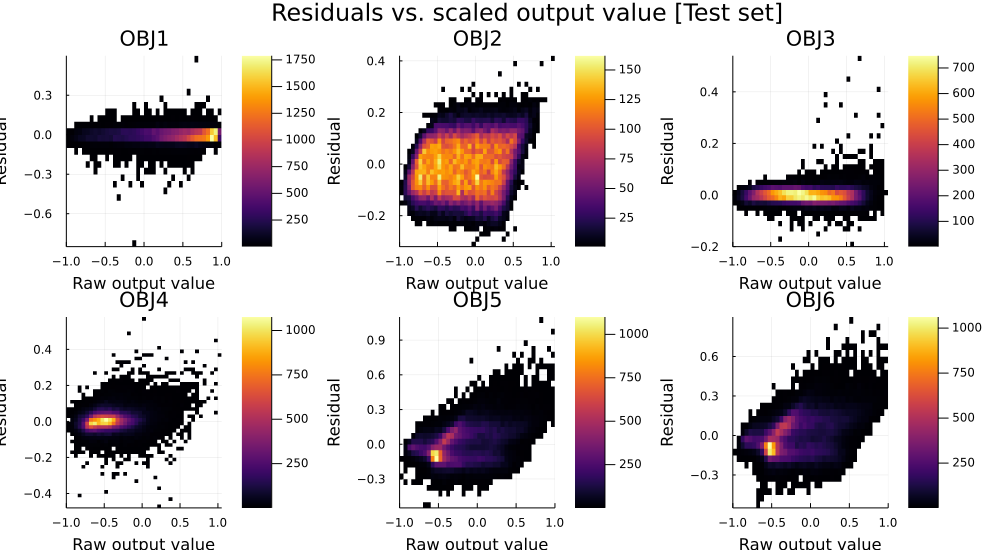

In [30]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")